# HSCT survival: Cox proportional hazards model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

feature_pval_cutoff=0.001
dataset='Nominal one-hot/ordinal encoded, NANs imputed'

# Dataset definition file
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'

# Feature type definitions file
feature_types_dict_file=f'{config.PROCESSED_DATA}/01.1-feature_type_dict.pkl'

# Output file
survival_file=f'{config.PROCESSED_DATA}/02.1-coxPH_survival.pkl'


## 1. Load data

In [2]:
# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

# Load one of the datasets
with open(datasets['Nominal one-hot/ordinal encoded, NANs encoded'], 'rb') as input_file:
    data_dict=pickle.load(input_file)

print('Data dictionary contains:\n')
for key, value in data_dict.items():
    print(f' {key}: {type(value)}')

# Combine features and labels
training_df=data_dict['Training features']
training_df[['efs', 'efs_time']]=data_dict['Training labels']

testing_df=data_dict['Testing features']
testing_df[['efs', 'efs_time']]=data_dict['Testing labels']

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Continuous target encoded

Feature types:

 Interval: ['donor_age', 'age_at_hct']

 Ordinal: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

 Nominal: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 't

In [3]:
training_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20160 entries, 0 to 20159
Data columns (total 142 columns):
 #    Column                                                Non-Null Count  Dtype  
---   ------                                                --------------  -----  
 0    psych_disturb_Yes                                     20160 non-null  int32  
 1    psych_disturb_missing                                 20160 non-null  int32  
 2    diabetes_Yes                                          20160 non-null  int32  
 3    diabetes_missing                                      20160 non-null  int32  
 4    tbi_status_>cGy                                       20160 non-null  int32  
 5    tbi_status_Cy                                         20160 non-null  int32  
 6    tbi_status_None                                       20160 non-null  int32  
 7    tbi_status_frac                                       20160 non-null  int32  
 8    tbi_status_missing                          

## 2. Cox proportional hazards model

### 2.1. Naive model

In [4]:
# Drop one low variance feature called out by CoxPHFitter()
training_df.drop('gvhd_proph_infrequent_sklearn', axis=1, inplace=True)
testing_df.drop('gvhd_proph_infrequent_sklearn', axis=1, inplace=True)

cph_model=CoxPHFitter()
cph_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 20160 total observations, 9292 right-censored observations>

### 2.2. Feature p-values

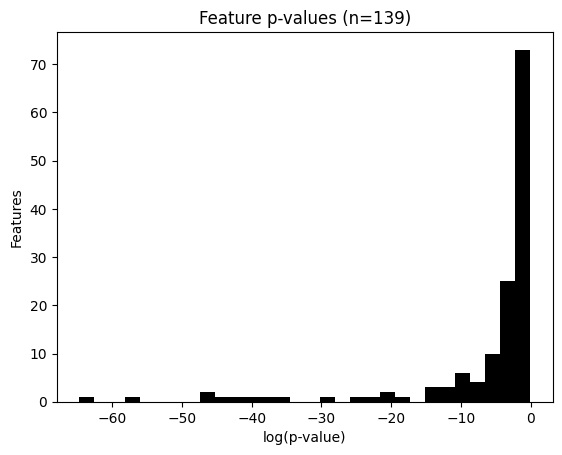

Significant features at alpha = 0.05: 53
Significant features at alpha = 0.001: 31


In [5]:
feature_pvals=cph_model.summary['p']

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(np.log(feature_pvals), color='black', bins=30)
plt.xlabel('log(p-value)')
plt.ylabel('Features')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

### 2.3. Feature selection

In [6]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

### 2.4. Model re-training

In [7]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

cph_model=CoxPHFitter()
cph_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 20160 total observations, 9292 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 20160
number of events observed = 10868
   partial log-likelihood = -102378.57
         time fit was run = 2025-02-26 03:13:41 UTC

---
                                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                             
psych_disturb_Yes                     0.10      1.11      0.03            0.05            0.16                1.05                1.17
diabetes_Yes                          0.13      1.14      0.03            0.08            0.18                1.08                1.20
tbi_status_>cGy                      -0.17      0.85      0.05           -0.25           -0.08                0.78                0.93
tbi_status_None                      -0.14      0.87      0.02           -0.18           -0.10                0.83                0.91
pulm_severe_Yes                       0.31      1.37      0.04            0.24            0.39                1.27                1.47
prim_disease_hct_HIS                 -0.93      0.39      0.14           -1.21           -0.66                0.30                0.52
prim_disease_hct_IEA                 -0.55      0.58      0.07           -0.69           -0.41                0.50                0.66
prim_disease_hct_IIS                 -0.80      0.45      0.09           -0.98           -0.62                0.38                0.54
prim_disease_hct_LEU                 -0.45      0.64      0.11           -0.67           -0.23                0.51                0.80
prim_disease_hct_NHL                 -0.18      0.84      0.05           -0.27           -0.09                0.76                0.92
prim_disease_hct_PCD                 -0.35      0.71      0.07           -0.49           -0.20                0.61                0.81
prim_disease_hct_SAA                 -0.32      0.72      0.08           -0.48           -0.17                0.62                0.84
conditioning_intensity_RIC            0.26      1.29      0.02            0.21            0.30                1.24                1.35
conditioning_intensity_missing       -0.59      0.55      0.04           -0.68           -0.50                0.51                0.60
mrd_hct_missing                       0.11      1.12      0.02            0.07            0.15                1.08                1.17
in_vivo_tcd_Yes                      -0.06      0.94      0.02           -0.11           -0.02                0.90                0.98
in_vivo_tcd_missing                  -0.50      0.61      0.12           -0.73           -0.26                0.48                0.77
hepatic_severe_Yes                   -0.26      0.77      0.05           -0.36           -0.15                0.70                0.86
sex_match_F-M                         0.28      1.33      0.02            0.24            0.33                1.27                1.39
sex_match_M-F                         0.23      1.26      0.02            0.18            0.28                1.20                1.32
race_group_Black or African-American  0.14      1.15      0.03            0.09            0.19                1.09                1.21
cardiac_Yes                           0.32      1.38      0.04            0.25            0.40                1.28                1.49
pulm_moderate_Yes                     0.09      1.09      0.02            0.04            0.13                1.04                1.14
hla_match_dqb1_low                    0.12      1.13      0.02            0.08            0.16                1.09                1.17
year_hct                             -0.04      0.96      0.00           -0.04           -0.03                0.96       

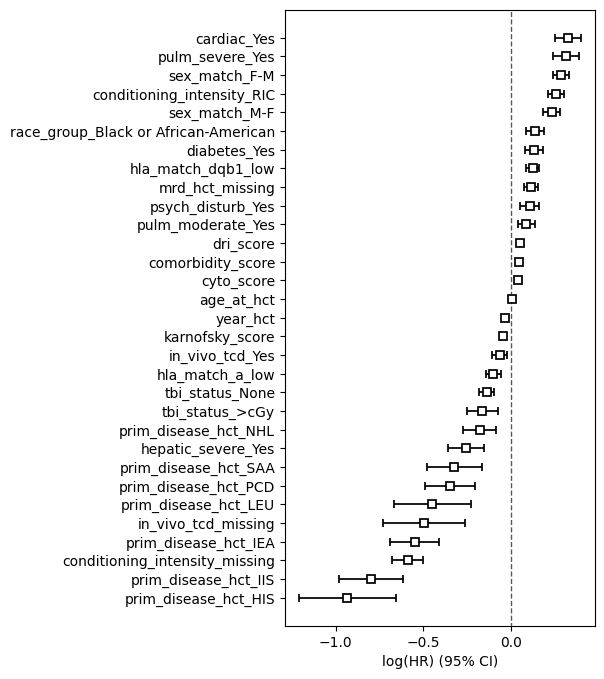

In [8]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

In [9]:
cph_model.check_assumptions(training_significant_features_df, p_value_threshold=feature_pval_cutoff)

The ``p_value_threshold`` is set at 0.001. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 20160 total observations, 9292 right-censored observations>
         test_name = proportional_hazard_test

---
                                           test_statistic      p  -log2(p)
age_at_hct                           km             32.19 <0.005     26.09
                                     rank           32.26 <0.005     26.14
cardiac_Yes                          km              0.07   0.80      0.33
                                     rank            0.07   0.80      0.33
comorbidity_score                    km             96.55 <0.005     73.28
                                     rank           96.93 <0.005     73.56
conditioning_intensity_RIC           km             21.00 <0.005     17.73
                                     rank           20.97 <0.005     17.71
conditioning_intensity_missing       km              0.84   0.36      1.48
                                     rank            0.85   0.36      1.48
cyto_score                           km             54.99 <0.005     42.91
                                     rank           55.01 <0.005     42.93
diabetes_Yes                         km              5.76   0.02      5.93
                                     rank            5.74   0.02      5.92
dri_score                            km             70.04 <0.005     53.93
                                     rank           70.07 <0.005     53.95
hepatic_severe_Yes                   km             11.02 <0.005     10.11
                                     rank           11.03 <0.005     10.12
hla_match_a_low                      km             43.20 <0.005     34.23
                                     rank           43.20 <0.005     34.24
hla_match_dqb1_low                   km              4.28   0.04      4.69
                                     rank            4.26   0.04      4.68
in_vivo_tcd_Yes                      km            181.72 <0.005    135.17
                                     rank          181.64 <0.005    135.11
in_vivo_tcd_missing                  km             12.30 <0.005     11.11
                                     rank           12.25 <0.005     11.07
karnofsky_score                      km              2.45   0.12      3.09
                                     rank            2.46   0.12      3.10
mrd_hct_missing                      km            287.56 <0.005    211.84
                                     rank          287.63 <0.005    211.90
prim_disease_hct_HIS                 km              0.26   0.61      0.72
                                     rank            0.26   0.61      0.71
prim_disease_hct_IEA                 km              2.29   0.13      2.94
                                     rank            2.29   0.13      2.94
prim_disease_hct_IIS                 km              1.50   0.22      2.18
                                     rank            1.50   0.22      2.18
prim_disease_hct_LEU                 km              1.36   0.24      2.03
                                     rank            1.36   0.24      2.03
prim_disease_hct_NHL                 km              0.91   0.34      1.55
                                     rank            0.91   0.34      1.55
prim_disease_hct_PCD                 km              0.51   0.47      1.08
                                     rank            0.51   0.48      1.07
prim_disease_hct_SAA                 km              0.73   0.39      1.35
                                     rank            0.73   0.39      1.35
psych_disturb_Yes                    km              1.22   0.27      1.90
                                     rank            1.24   0.27      1.91
pulm_moderate_Yes                    km              3.10   0.08      3.67
                                     rank            3.11   0.08      3.69
pulm_severe_Yes                      km      



1. Variable 'conditioning_intensity_RIC' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include
`strata=['conditioning_intensity_RIC', ...]` in the call in `.fit`. See documentation in link [E]
below.

2. Variable 'mrd_hct_missing' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['mrd_hct_missing', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'in_vivo_tcd_Yes' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['in_vivo_tcd_Yes', ...]` in
the call in `.fit`. See documentation in link [E] below.

4. Variable 'in_vivo_tcd_missing' failed the non-proportional test: p-value is 0.0005.

   Advice: with so few unique values (only 2), you can include `strata=['in_vivo_tcd_missing', ...]`
in the call in `.fit`. See documentation in link [E] below.



[]

## 3. Survival forecasting

In [10]:
# Predict new survival function for training participants
training_survival_functions=cph_model.predict_survival_function(training_significant_features_df)
training_partial_hazards=cph_model.predict_partial_hazard(training_significant_features_df)
training_survival_df=training_df[['efs', 'efs_time']].copy()
training_survival_df['Survival']=training_survival_functions.iloc[-1]
training_survival_df['Partial hazard']=training_partial_hazards

# Predict new survival function for testing participants
testing_survival_functions=cph_model.predict_survival_function(testing_significant_features_df)
testing_partial_hazards=cph_model.predict_partial_hazard(testing_significant_features_df)
testing_survival_df=testing_df[['efs', 'efs_time']].copy()
testing_survival_df['Survival']=testing_survival_functions.iloc[-1]
testing_survival_df['Partial hazard']=testing_partial_hazards

training_survival_df.head()

,efs,efs_time,Survival,Partial hazard
0,1.0,2.142,0.243637,1.880348
1,0.0,105.944,0.363744,1.346671
2,0.0,34.787,0.516802,0.878995
3,1.0,6.964,0.194666,2.179151
4,1.0,5.541,0.388247,1.259862


### 3.1. Survival curves

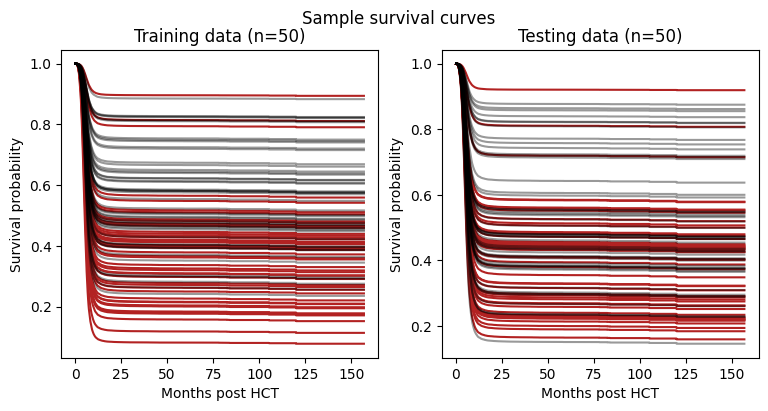

In [11]:
n_curves=50

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Sample survival curves')

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title(f'Training data (n={n_curves})')

for i in range(n_curves):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Months post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title(f'Testing data (n={n_curves})')

for i in range(n_curves):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Months post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 3.2. Survival probability at study end

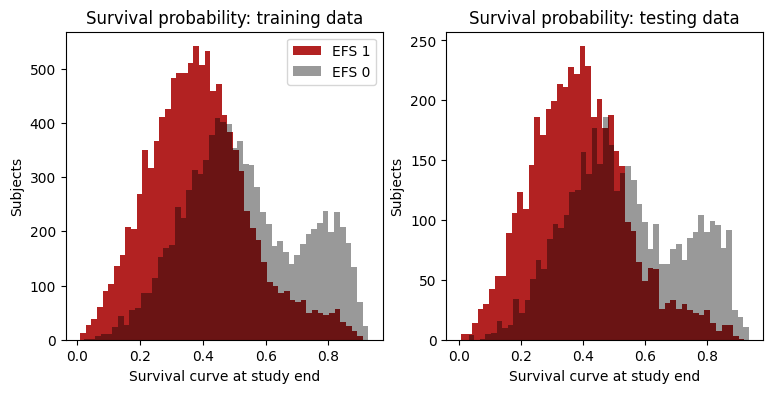

In [12]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at study end')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at study end')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.3. Partial hazard

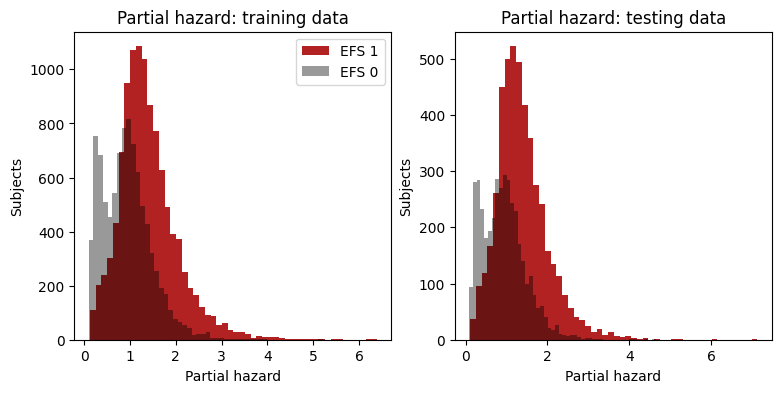

In [13]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Partial hazard: training data')
axs[0].hist(efs_positive_df['Partial hazard'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Partial hazard'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Partial hazard')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Partial hazard: testing data')
axs[1].hist(efs_positive_df['Partial hazard'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Partial hazard'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Partial hazard')
axs[1].set_ylabel('Subjects')

plt.show()

### 3.4. C-index scoring

In [14]:
scoring_results=helper_funcs.score_predictions(
    'CoxPH survival',
    testing_survival_df['Survival'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs']
)

scoring_results=helper_funcs.score_predictions(
    'CoxPH partial hazard',
    -testing_survival_df['Partial hazard'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    data_dict['Testing race group'],
    data_dict['Testing IDs'],
    results=scoring_results
)

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,CoxPH survival,33.335209,0.648375,0.628934
1,CoxPH partial hazard,34.400973,0.648375,0.628934


## 4. Save survival features

In [15]:
coxph_features={
    'Training survival': list(training_survival_df['Survival'].values),
    'Training partial hazard': list(training_survival_df['Partial hazard'].values),
    'Testing survival': list(training_survival_df['Survival'].values),
    'Testing partial hazard': list(training_survival_df['Partial hazard'].values)
}

with open(survival_file, 'wb') as output_file:
    pickle.dump(coxph_features, output_file)